# Step 1: Estimate a starting ρ from the length model by maximum likelihood.

The independent loss length model is a
Markov process known as an M/M/∞ queuing model
[28] (Figure 2A). In this queuing model, customers
(i.e., spacers) arrive according to a Poisson process with
rate λ. They are immediately served and exit after an
exponential waiting time with rate μ. The stationary distribution
of the number of busy servers (i.e., the number
of spacers in the array), is a Poisson distribution with
rate ρ:

ro = $$\rho = \frac{\lambda}{\mu}$$
with $\lambda$ = spacer insertion rate, $\mu$ = spacer_deletion_rate

prob_n_given_ro = $$p(n|\rho) = e^{-\rho} \frac{\rho^n}{n!}$$

## ML of $p(n|\rho)$ is the mean length of arrays

In [286]:
import numpy as np
from mpmath import *
mp.dps = 100; mp.pretty = True

arrays=[[9,2,3,4,5],[0,1,2,3,7,8],[1,10,11,12,13],[13,14]]
# arrays=[[9,2,3,4,5],[0,1,2,3,7,8],[1,10,11,12,13]]


rho_init=mpf(sum([len(ar) for ar in arrays])/len([len(ar) for ar in arrays]))

rho_init

4.5

# Step 2: For each pair of spacers with overlap, generate the possible ancestors (doesnt need to actually generate the arrays)

Ancestral arrays can be arbitrarily
    large, but the probability of observing a certain
    length is given by p(n). For practical reasons we do
    not consider ancestors whose length is outside the
    central 99% of the stationary distribution given by ρ
    estimated in step 1, since they would have a
    negligible contribution to the likelihood. In detail, the
    length l1 where the cumulative distribution exceeds
    0.005 is the minimum ancestor length and the length
    l2 where the cumulative distribution exceeds 0.995 is
    the maximum ancestor length. Then the possible
    ancestor lengths n are between l1 and l2: l1 ≤ n ≤ l2.

### 2.1: Find pairs of spacers that overlap

In [44]:
from CRISPR_functions import is_overlapping
import itertools
from itertools import combinations

arrays=[[9,2,3,4,5],[0,1,2,3,7,8],[1,10,11,12,13],[14,15]]

overlapping_arrays=[pair for pair in list(itertools.combinations(arrays,2)) if is_overlapping(pair[0],pair[1])==1]

overlapping_arrays

[([9, 2, 3, 4, 5], [0, 1, 2, 3, 7, 8]),
 ([0, 1, 2, 3, 7, 8], [1, 10, 11, 12, 13])]

### 2.1: Find ancestor array size limits to exclude arrays outside of the 99% length distribution

In [45]:
from CRISPR_functions import get_limits_ancestor_sizes

size_lims=get_limits_ancestor_sizes(arrays)
size_lims

(0, 11)

### 2.2: Generate all possible ancestors for a pair within the size limits

In [46]:
from CRISPR_functions import CRISPR_pair
import importlib
importlib.reload(CRISPR_functions) 

pair=overlapping_arrays[0]
s1=pair[0]
s2=pair[1]
PAIR=CRISPR_pair(s1,s2)
print(pair)
print(PAIR.get_combi.__doc__)

# print(PAIR.get_combi(size_lims))

print('\n'.join([' : '.join([k,str(v)]) for k,v in PAIR.get_combi(size_lims).items()]))

([9, 2, 3, 4, 5], [0, 1, 2, 3, 7, 8])
 The function get_combi outputs a dictionary of all the possible combinations of spacers categories and their corresponding adjusted (per ancestor length) weights. 
        {c-i-j-u:ws} with:
        c number of spacers in common (spacers necessarily present in ancerstor), 
        i number of ancestral spacers amongst the spacers only present in array1, 
        j number of ancestral spacers amongt these only present in array2,
        u number of ancestral spacers lost in both array1 and array2,
        ws weight of each putative ancestral array from this combi.
        l1 (min ancestor length) and l2 (max ancestor length) have to be provided
        n length of ancestral array = sum(c,i,j,u) 
6-0-0-0 : 1.0
6-0-0-1 : 0.7777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777778
6-0-1-0 : 0.1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
6-1-0-0 : 0.11111

# Step 3: For all pairs with overlap ...

## 3.1 Estimate the times with fixed ρ. 
It is possible to iterate through
the pairs and estimate their times
independently of the other pairs. The
estimation of both times is iterated
alternatingly until the likelihood has
converged.

In [282]:
import CRISPR_functions
from CRISPR_functions import OPTIMIZE_t1t2
import importlib
importlib.reload(CRISPR_functions) 
rho_init=mpf(sum([len(ar) for ar in arrays])/len([len(ar) for ar in arrays]))
print(rho_init)
size_lims=get_limits_ancestor_sizes(arrays)

print(OPTIMIZE_t1t2.__doc__)
t1t2_list=OPTIMIZE_t1t2(overlapping_arrays, rho_init, size_lims)
print(t1t2_list)

4.5
Provided a set of overlapping arrays and rho, OPTIMIZE_t1t2 finds their best respective divergence times t1,t2 from ancestor to arrays. The output is an array of [t1,t2] of length len(overlapping_arrays)
[(2.562247762846972, 2.561870317220544), (4.15797174241843, 4.1727451210474085)]


## 3.2 Estimate ρ with fixed times using L(ρ|t, S).

In [283]:
import CRISPR_functions
from CRISPR_functions import CRISPR_pair,OPTIMIZE_rho
import importlib
importlib.reload(CRISPR_functions) 

# size_lims=get_limits_ancestor_sizes(arrays)
pair_list=[CRISPR_pair(pair[0],pair[1]) for pair in overlapping_arrays]
non_overlapping_arrays=[pair for pair in list(itertools.combinations(arrays,2)) if is_overlapping(pair[0],pair[1])==0]
print(size_lims)
(rho_update, neg_LL_update) = OPTIMIZE_rho(t1t2_list,pair_list,size_lims,non_overlapping_arrays)
print(rho_update)
print(neg_LL_update)

(0, 11)
[4.98664945]
[48.2565508224993]


## 3.3 Check if the log-likelihood of the estimated parameters has converged,
then return the
estimated parameters, else repeat step 3.1
with the new parameters.

In [284]:
Init_LL=[np.inf]
i=0
step_list=[0]
rho_list=[rho_update]
convergence='False'
while convergence=='False':
    i+=1
    step_list+=[i]
    previous_LL=Init_LL[-1]
    t1t2_list=OPTIMIZE_t1t2(overlapping_arrays, rho_update, size_lims)
    OPTIMIZE_rho(t1t2_list,pair_list,size_lims,non_overlapping_arrays)
    (rho_update, neg_LL_update) = OPTIMIZE_rho(t1t2_list,pair_list,size_lims,non_overlapping_arrays)
    Init_LL+=[neg_LL_update[0]]
    rho_list+=[rho_update]
    
    print(previous_LL,neg_LL_update[0])
    if neg_LL_update[0]>previous_LL:
        convergence='True'
    

inf 48.22557486609799
48.22557486609799 48.22534998793841
48.22534998793841 48.22534832512889
48.22534832512889 48.225348312559355
48.225348312559355 48.22534831244816
48.22534831244816 48.22534831244487
48.22534831244487 48.22534831244592


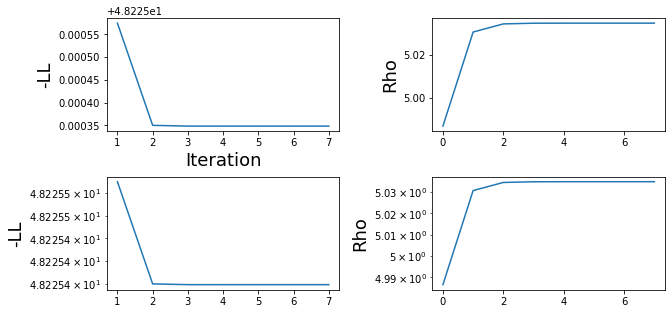

In [285]:
import matplotlib.pyplot as plt


fig,axarr = plt.subplots(2,2,figsize=(10,5))
fig.subplots_adjust(wspace=0.4,hspace=0.4)
axarr = axarr.flatten()


ax = axarr[0]
X=step_list
Y = Init_LL
ax.plot(X, Y)
ax.set_xlabel('Iteration',fontsize=18)
ax.set_ylabel('-LL',fontsize=18)


ax = axarr[1]
X=step_list
Y = rho_list
ax.plot(X, Y)
ax.set_ylabel('Rho',fontsize=18)


ax = axarr[2]
X=step_list
Y = Init_LL
ax.plot(X, Y)
ax.set_ylabel('-LL',fontsize=18)
ax.set_yscale("log")


ax = axarr[3]
X=step_list
Y = rho_list
ax.semilogy(X, Y)
ax.set_ylabel('Rho',fontsize=18)
#ax.set_yscale("log")
plt.show()

# ALL TOGETHER : Find Optimum distances

This function is not yet implemented in CRISPR_functions, I will probably create a class for array list. But before, I want to parallelize it

In [57]:
#f=open('arrays_with_at_least_5_reads_in_whole_dataset.txt','r')
#f=open('arrays_with_at_least_50_reads_in_whole_dataset.txt','r')
f=open('arrays_with_at_least_5percent_in_reads.txt','r')
lines=f.read().splitlines()
lines=[line.split('\t')[2] for line in lines]
f.close()
myarrays=[line.split(',') for line in lines]
print(len(myarrays))
print(myarrays)



10
[['5', '170', '999', '998', '997', '22', '79', '161', '174', '179', '37', '47', '440', '184', '55', '58', '295'], ['5', '170', '999', '998', '997', '22', '79', '161', '174', '179', '440', '184', '55', '58', '295'], ['5', '170', '161', '174', '179', '37', '47', '440', '184', '55', '58', '295'], ['5', '170', '161', '174', '179', '37', '440', '184', '55', '58', '295'], ['5', '170', '161', '174', '179', '37', '47', '184', '55', '58', '295'], ['5', '170', '161', '174', '179', '37', '47', '440', '184', '58', '295'], ['5', '170', '174', '179', '37', '47', '440', '184', '55', '295'], ['5', '170', '161', '174', '179', '37', '47', '440', '184', '55', '295'], ['5', '170', '161', '174', '179', '47', '440', '184', '55', '295'], ['5', '170', '161', '184', '55', '295']]


In [58]:
import time
from mpmath import mpf
import itertools
from itertools import combinations
import numpy as np
import CRISPR_functions
from CRISPR_functions import get_limits_ancestor_sizes,CRISPR_pair, OPTIMIZE_rho,OPTIMIZE_t1t2,is_overlapping
import importlib
importlib.reload(CRISPR_functions)

def find_optimum_rho_and_distances_ordered_model(arrays):
    '''
    Given a list of arrays as input, optimize rho and t for the ordered model
    
    Output:dictionnary of pairs and their respecive distances, rho
    
    
    '''
    
    overlapping_arrays=[pair for pair in list(itertools.combinations(arrays,2)) if is_overlapping(pair[0],pair[1])==1]

    ## first step
    rho_init=mpf(sum([len(ar) for ar in arrays])/len([len(ar) for ar in arrays]))
    size_lims=get_limits_ancestor_sizes(arrays)
    t1t2_list=OPTIMIZE_t1t2(overlapping_arrays, rho_init, size_lims)
    pair_list=[CRISPR_pair(pair[0],pair[1]) for pair in overlapping_arrays]
    non_overlapping_arrays=[pair for pair in list(itertools.combinations(arrays,2)) if is_overlapping(pair[0],pair[1])==0]
    (rho_update, neg_LL_update) = OPTIMIZE_rho(t1t2_list,pair_list,size_lims,non_overlapping_arrays)
    print('time to finish first step',time.time()-t0,'seconds')
    ## iterate
    Init_LL=[np.inf]
    i=0
    step_list=[0]
    rho_list=[rho_update]
    convergence='False'
    while convergence=='False':
        i+=1
        print('iteration '+str(i)+'...')
        step_list+=[i]
        previous_LL=Init_LL[-1]
        t1t2_list=OPTIMIZE_t1t2(overlapping_arrays, rho_update, size_lims)
        OPTIMIZE_rho(t1t2_list,pair_list,size_lims,non_overlapping_arrays)
        (rho_update, neg_LL_update) = OPTIMIZE_rho(t1t2_list,pair_list,size_lims,non_overlapping_arrays)
        Init_LL+=[neg_LL_update[0]]
        rho_list+=[rho_update]
        if neg_LL_update[0]>previous_LL:
            convergence='True'
    final_dist=dict(zip(pair_list,t1t2_list))
    return(final_dist,rho_list[-1:])

#arrays=[[9,2,3,4,5],[0,1,2,3,7,8],[1,10,11,12,13],[13,14]]
arrays=myarrays
t0 = time.time()

final_dist,rho=find_optimum_rho_and_distances_ordered_model(arrays)

print('time to completion',time.time()-t0,'seconds')

time to finish first step 18.227087020874023 seconds
iteration 1...
iteration 2...
iteration 3...
iteration 4...
iteration 5...
iteration 6...
iteration 7...
iteration 8...
time to completion 188.5966739654541 seconds


# Get phylogeny from CRISPR distances

I think I calculate the weights wrong... Should try a simulated dataset

{0: '5-170-999-998-997-22-79-161-174-179-37-47-440-184-55-58-295', 1: '5-170-999-998-997-22-79-161-174-179-440-184-55-58-295', 2: '5-170-161-174-179-37-47-440-184-55-58-295', 3: '5-170-161-174-179-37-440-184-55-58-295', 4: '5-170-161-174-179-37-47-184-55-58-295', 5: '5-170-161-174-179-37-47-440-184-58-295', 6: '5-170-174-179-37-47-440-184-55-295', 7: '5-170-161-174-179-37-47-440-184-55-295', 8: '5-170-161-174-179-47-440-184-55-295', 9: '5-170-161-184-55-295', '5-170-999-998-997-22-79-161-174-179-37-47-440-184-55-58-295': 0, '5-170-999-998-997-22-79-161-174-179-440-184-55-58-295': 1, '5-170-161-174-179-37-47-440-184-55-58-295': 2, '5-170-161-174-179-37-440-184-55-58-295': 3, '5-170-161-174-179-37-47-184-55-58-295': 4, '5-170-161-174-179-37-47-440-184-58-295': 5, '5-170-174-179-37-47-440-184-55-295': 6, '5-170-161-174-179-37-47-440-184-55-295': 7, '5-170-161-174-179-47-440-184-55-295': 8, '5-170-161-184-55-295': 9}


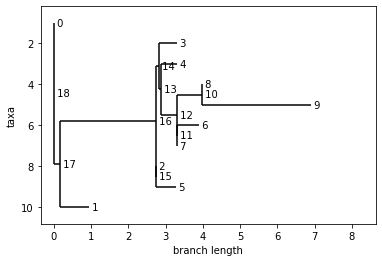

                                                   0
0  5-170-999-998-997-22-79-161-174-179-37-47-440-...
1  5-170-999-998-997-22-79-161-174-179-440-184-55...
2          5-170-161-174-179-37-47-440-184-55-58-295
3             5-170-161-174-179-37-440-184-55-58-295
4              5-170-161-174-179-37-47-184-55-58-295
5             5-170-161-174-179-37-47-440-184-58-295
6                 5-170-174-179-37-47-440-184-55-295
7             5-170-161-174-179-37-47-440-184-55-295
8                5-170-161-174-179-47-440-184-55-295
9                               5-170-161-184-55-295


In [107]:
import CRISPR_functions
from CRISPR_functions import phylogeny_from_CRISPR
import pandas as pd
from Bio.Phylo import BaseTree,draw_ascii

import importlib
importlib.reload(CRISPR_functions)

#arrays=[[9,2,3,4,5],[0,1,2,3,7,8],[1,10,11,12,13],[13,14]]
arrays=myarrays

Tree,labels=phylogeny_from_CRISPR(arrays,final_dist)
print(labels)
# draw_ascii(Tree)
Phylo.draw(Tree)
#Phylo.write(Tree,'Test_tree.nwk','newick')
#Phylo.write(Tree,'Test_mytree.nwk','newick')
Phylo.write(Tree,'Test_mytree_main_arrays.nwk','newick')
labs=pd.DataFrame.from_dict(labels,orient='index').iloc[:int(len(labels)/2)]
print(labs)

In [94]:
def get_distance_matrix_from_phylogeny(Tree):
    taxa=sorted(map(int,[cl.name for cl in Tree.get_terminals()]))
    matrix=pd.DataFrame([],columns=taxa,index=taxa)
    for combi in combinations(range(len(taxa)),2):
        tgt1=str(combi[0])
        tgt2=str(combi[1])
        dist=Tree.distance({"name": tgt1}, {"name": tgt2})
        matrix.loc[combi]=dist
        matrix.loc[combi[1],combi[0]]=dist
    return(matrix)
dist=get_distance_matrix_from_phylogeny(Tree)
dist.to_csv('arrays_with_at_least_5percent_in_reads.dist',sep='\t',index=False)
